# COVID-19 대한민국 해외 유입 확진자 예측 모델 : LSTM

In [59]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import warnings
warnings.filterwarnings('ignore')

# 1. Load Dataset

In [76]:
df = pd.read_csv('./data/total.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('Date', inplace=True)

In [77]:
df.rename(columns={'TARGET':'oversea_inflow'}, inplace=True)

In [78]:
df['target'] = df['oversea_inflow'].diff()

In [79]:
cols = ['EURO_conf',
 'CHINA_conf',
 'ASIA_conf',
 'AMERICA_conf',]

In [80]:
cols

['EURO_conf', 'CHINA_conf', 'ASIA_conf', 'AMERICA_conf']

In [81]:
t_cols = []
for col in cols:
    tmp = '{}_1'.format(col)
    t_cols.append(tmp)
    df[tmp] = df['{}'.format(col)].diff()

In [82]:
df.isnull().sum()

EURO_conf         0
CHINA_conf        0
ASIA_conf         0
AMERICA_conf      0
EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
target            1
EURO_conf_1       1
CHINA_conf_1      1
ASIA_conf_1       1
AMERICA_conf_1    1
dtype: int64

In [83]:
t_cols

['EURO_conf_1', 'CHINA_conf_1', 'ASIA_conf_1', 'AMERICA_conf_1']

In [84]:
df.head()

,EURO_conf,CHINA_conf,ASIA_conf,AMERICA_conf,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,,,,,
2020-01-22,0,548,5,1,1955.0,3014.0,8946.0,701.0,1,NaN,NaN,NaN,NaN,NaN
2020-01-23,0,643,9,1,1913.0,2677.0,7924.0,943.0,1,0.0,0.0,95.0,4.0,0.0
2020-01-24,2,920,15,2,2286.0,2197.0,7356.0,864.0,2,1.0,2.0,277.0,6.0,1.0
2020-01-25,3,1406,17,2,1472.0,1825.0,7518.0,828.0,2,0.0,1.0,486.0,2.0,0.0
2020-01-26,3,2075,22,5,1932.0,3252.0,11149.0,900.0,3,1.0,0.0,669.0,5.0,3.0


In [85]:
df.loc['2020-01-22',t_cols] = 0
df.target.iloc[0] = 0

In [86]:
# 일일 해외유입 확진자를 구할때 첫번째 로우는 NaN이기 때문에 0값을 넣어준다.
df['target'][0] = 0

In [87]:
df.drop(cols, axis=1, inplace=True)

In [88]:
df.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1
Date,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,2.0,1900.0,15.0,4431.0,36188.0
2020-04-25,34.0,73.0,298.0,108.0,1027,4.0,13407.0,10.0,4266.0,32796.0
2020-04-26,62.0,126.0,294.0,100.0,1037,10.0,10354.0,3.0,4027.0,27631.0
2020-04-27,50.0,67.0,194.0,106.0,1044,7.0,12612.0,6.0,4311.0,22412.0
2020-04-28,15.0,143.0,224.0,102.0,1056,12.0,11645.0,22.0,3456.0,24385.0


## lag 변수 생성

In [89]:
lag_amount = 14

for i in range(lag_amount):
    df['lag{}'.format(i+1)] = df['target'].shift(i+1)
    
df.dropna(inplace=True)

In [90]:
df.head()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1,...,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-05,1586.0,1238.0,6130.0,681.0,13,2.0,0.0,3733.0,4.0,0.0,...,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2020-02-06,1549.0,1089.0,6341.0,820.0,15,2.0,0.0,3147.0,7.0,0.0,...,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2020-02-07,1985.0,1132.0,6526.0,845.0,15,0.0,3.0,3523.0,5.0,0.0,...,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0
2020-02-08,1686.0,1132.0,6756.0,1113.0,15,0.0,5.0,2704.0,16.0,0.0,...,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0
2020-02-09,1964.0,1205.0,7272.0,1206.0,15,0.0,2.0,3015.0,9.0,0.0,...,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0


In [91]:
df.tail()

,EURO_roam,CHINA_roam,ASIA_roam,AMERICA_roam,oversea_inflow,target,EURO_conf_1,CHINA_conf_1,ASIA_conf_1,AMERICA_conf_1,...,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-24,39.0,197.0,311.0,99.0,1023,2.0,1900.0,15.0,4431.0,36188.0,...,5.0,10.0,16.0,12.0,15.0,11.0,17.0,26.0,17.0,8.0
2020-04-25,34.0,73.0,298.0,108.0,1027,4.0,13407.0,10.0,4266.0,32796.0,...,8.0,5.0,10.0,16.0,12.0,15.0,11.0,17.0,26.0,17.0
2020-04-26,62.0,126.0,294.0,100.0,1037,10.0,10354.0,3.0,4027.0,27631.0,...,5.0,8.0,5.0,10.0,16.0,12.0,15.0,11.0,17.0,26.0
2020-04-27,50.0,67.0,194.0,106.0,1044,7.0,12612.0,6.0,4311.0,22412.0,...,6.0,5.0,8.0,5.0,10.0,16.0,12.0,15.0,11.0,17.0
2020-04-28,15.0,143.0,224.0,102.0,1056,12.0,11645.0,22.0,3456.0,24385.0,...,4.0,6.0,5.0,8.0,5.0,10.0,16.0,12.0,15.0,11.0


# Data Exploration

In [92]:
# 결측치 확인
df.isnull().sum()

EURO_roam         0
CHINA_roam        0
ASIA_roam         0
AMERICA_roam      0
oversea_inflow    0
target            0
EURO_conf_1       0
CHINA_conf_1      0
ASIA_conf_1       0
AMERICA_conf_1    0
lag1              0
lag2              0
lag3              0
lag4              0
lag5              0
lag6              0
lag7              0
lag8              0
lag9              0
lag10             0
lag11             0
lag12             0
lag13             0
lag14             0
dtype: int64

In [93]:
# 데이터 프레임 형태 확인
print("전체 데이터 shape: {}".format(df.shape))
print("target feature shape: {}".format(df['target'].shape))

전체 데이터 shape: (84, 24)
target feature shape: (84,)


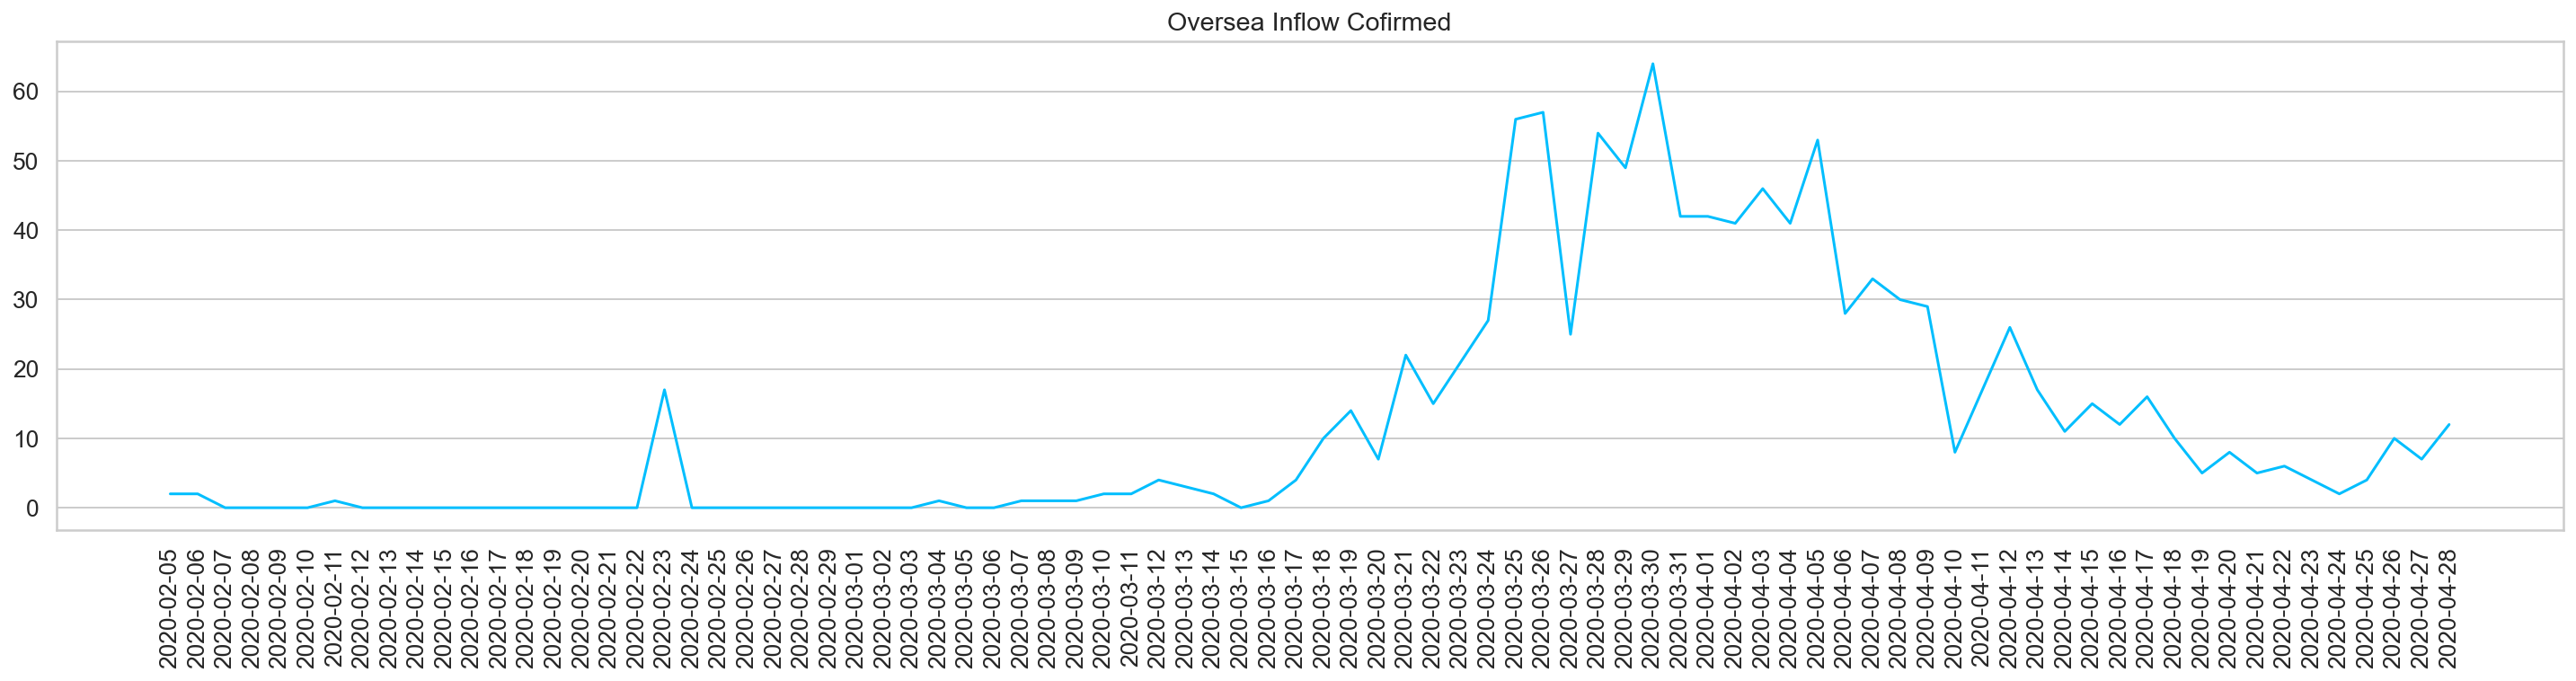

In [94]:
plt.figure(figsize=(25,5))
plt.plot(df['target'])
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')

# Preprocessing

In [95]:
# 테스트 데이터 수
test_data_size = 21

# X변수들과 y변수 구분
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [96]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X)
# Y scaler 생성
yscaler = scaler.fit(y.values.reshape(-1,1))

# 스케일링 적용
X = Xscaler.transform(X)
y = yscaler.transform(y.values.reshape(-1,1))

# Train, Test set split
X_train, X_test = X[:-test_data_size], X[-test_data_size:]
y_train, y_test = y[:-test_data_size].flatten(), y[-test_data_size:].flatten()

In [97]:
print("train set : ", X_train.shape)
print("test set : ", X_test.shape)

train set :  (63, 23)
test set :  (21, 23)


In [98]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [99]:
# 시퀀스 길이
seq_length = 1

X_train = create_sequences1(X_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
X_test = create_sequences1(X_test, seq_length)
y_test = create_sequences1(y_test, seq_length)

In [100]:
# numpy -> tensor 변환
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [101]:
print("X_train :",(X_train.shape))
print("X_test :",(X_test.shape))
print("y_train :",(y_train.shape))
print("y_test :",(y_test.shape))

X_train : torch.Size([61, 1, 23])
X_test : torch.Size([19, 1, 23])
y_train : torch.Size([61, 1])
y_test : torch.Size([19, 1])


# Building a Model

In [102]:
# Model Class 생성

class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        num_layers = n_layers,
        #dropout=0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        
    def reset_hidden_state(self):
            self.hidden = (
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
    
        return y_pred

## __Training__

In [103]:
def train_model(model, train_data, train_labels, test_data=None, test_labels=None, num_epochs=250, lr=1e-3):
    loss_fn = torch.nn.MSELoss()
    
    optimiser = torch.optim.Adam(model.parameters(), lr=lr, )
    num_epochs = num_epochs
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(X_test)
                test_loss = loss_fn(y_test_pred.float(), y_test)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
            
        train_hist[t] = loss.item()
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model.eval(), train_hist, test_hist

In [124]:
# Hyper-parameter 설정
n_features=X_train.shape[-1]
n_hidden=32
n_layers=8
lr=1e-4
num_epochs=250

# Training Model
model = CoronaVirusPredictor(n_features=n_features, n_hidden=n_hidden, seq_len=seq_length, n_layers=n_layers)
model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.004760098643600941 test loss: 0.38953372836112976
Epoch 10 train loss: 0.0047334046103060246 test loss: 0.3832273781299591
Epoch 20 train loss: 0.0047195106744766235 test loss: 0.38464125990867615
Epoch 30 train loss: 0.004704208113253117 test loss: 0.3834203779697418
Epoch 40 train loss: 0.004685737658292055 test loss: 0.3833634555339813
Epoch 50 train loss: 0.004660428036004305 test loss: 0.38264399766921997
Epoch 60 train loss: 0.004619411658495665 test loss: 0.3812825083732605
Epoch 70 train loss: 0.004541380330920219 test loss: 0.3790575861930847
Epoch 80 train loss: 0.004375905729830265 test loss: 0.37347280979156494
Epoch 90 train loss: 0.004021765664219856 test loss: 0.35993072390556335
Epoch 100 train loss: 0.0033954123500734568 test loss: 0.3278582692146301
Epoch 110 train loss: 0.0027999889571219683 test loss: 0.27287742495536804
Epoch 120 train loss: 0.002445419318974018 test loss: 0.2253999412059784
Epoch 130 train loss: 0.002167301019653678 test loss

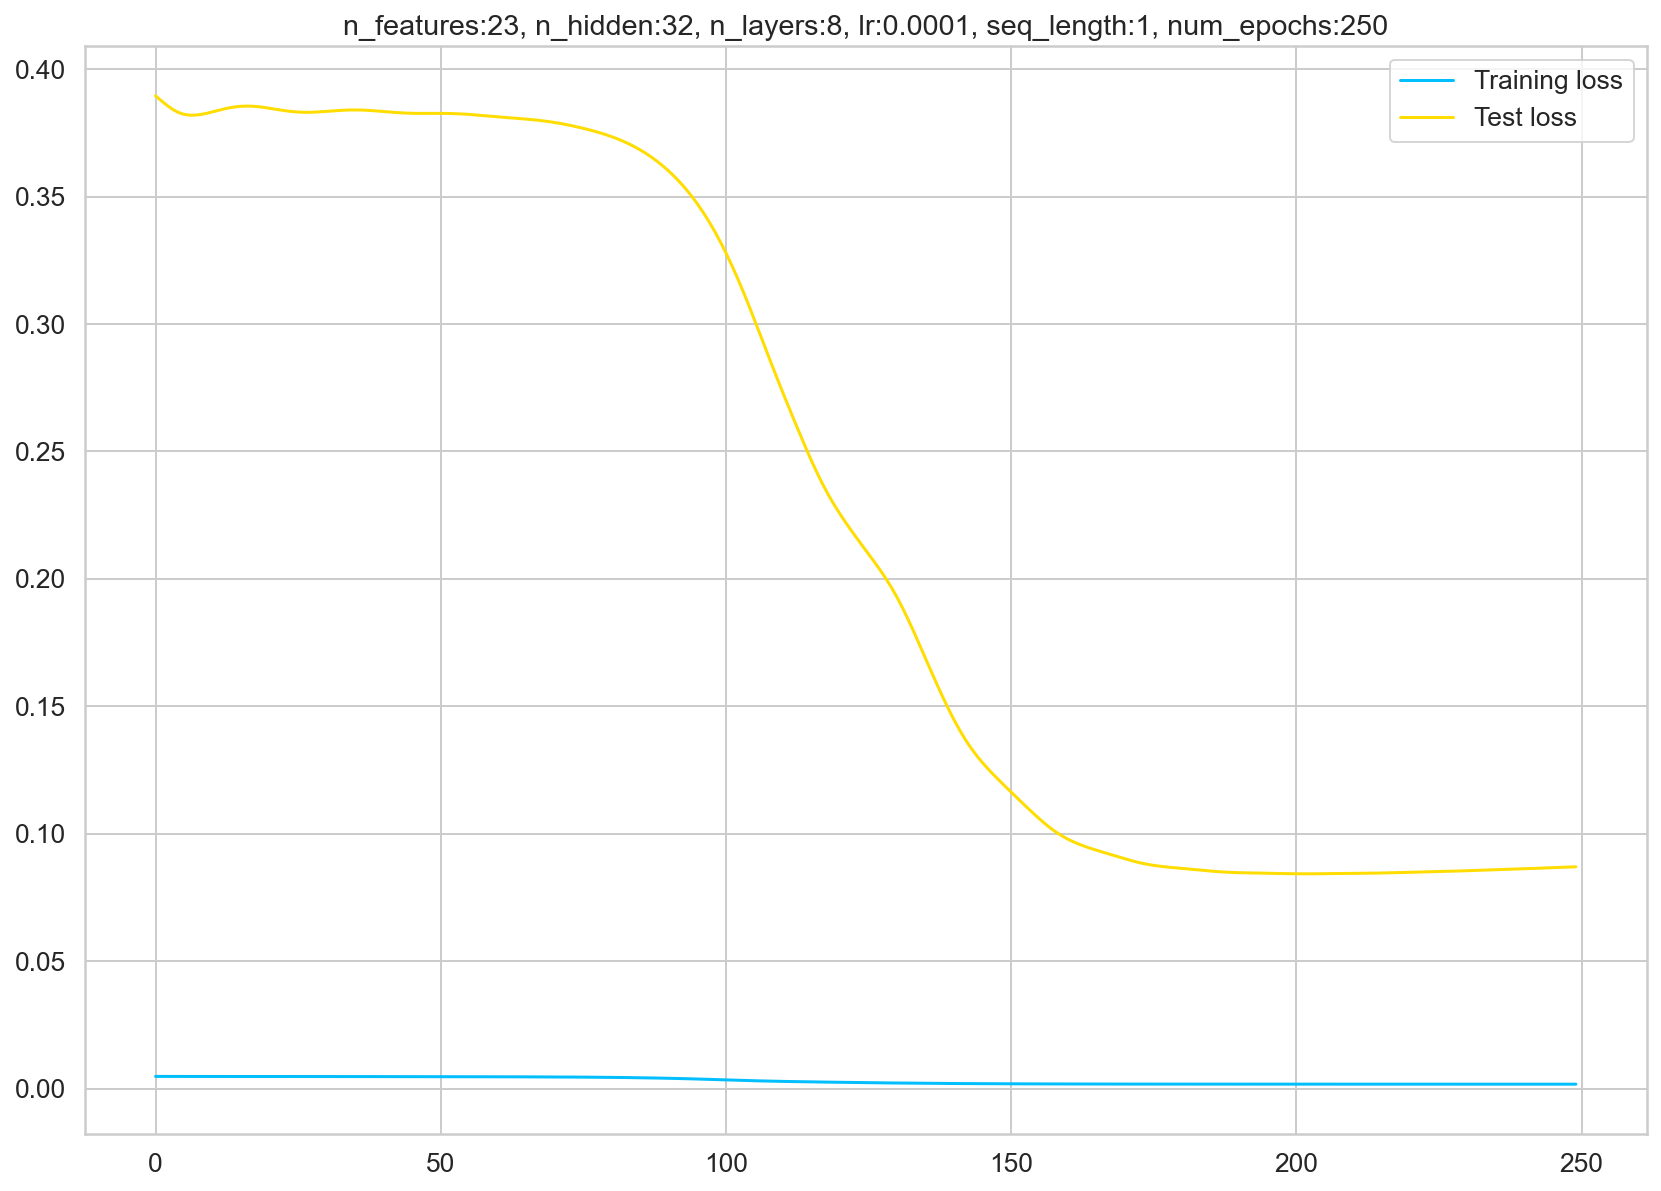

In [125]:
# plotting Loss
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.title('n_features:{0}, n_hidden:{1}, n_layers:{2}, lr:{3}, seq_length:{4}, num_epochs:{5}'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs))
plt.legend()

In [126]:
# 모델 저장
PATH = './models/LSTM_seq1_n_features_{0}_n_hidden_{1}_n_layers_{2}_lr_{3}_seq_length_{4}_num_epochs_{5}.pth'.format(n_features,n_hidden,n_layers,lr,seq_length,num_epochs)
torch.save(model, PATH)
# 모델 불러오기
model = torch.load(PATH)
#model.eval()

# Predicting daily cases

In [127]:
with torch.no_grad():
    
    preds = []
    for i in range(len(X_test)):
        test_seq = X_test[i:i+1]
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, pred)
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(n_features, seq_length, 1).float()

In [128]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [129]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
pred_values_ceiled

[32, 32, 31, 30, 30, 29, 27, 26, 25, 24, 22, 21, 20, 18, 17, 16, 15, 14, 13]

In [130]:
# True value 스케일링 역변환
true_values = yscaler.inverse_transform(y_test)[:, [-1]]

In [131]:
# 실제값 예측값 데이터 프레임 생성
score_table = pd.DataFrame({'True':true_values.flatten(),
                            'Pred':pred_values_ceiled})

In [132]:
# validation score
score = 100*(1-(((score_table['Pred'] -score_table['True'])**2).sum())/((score_table['True']**2).sum()))

In [133]:
score

79.13992883428119

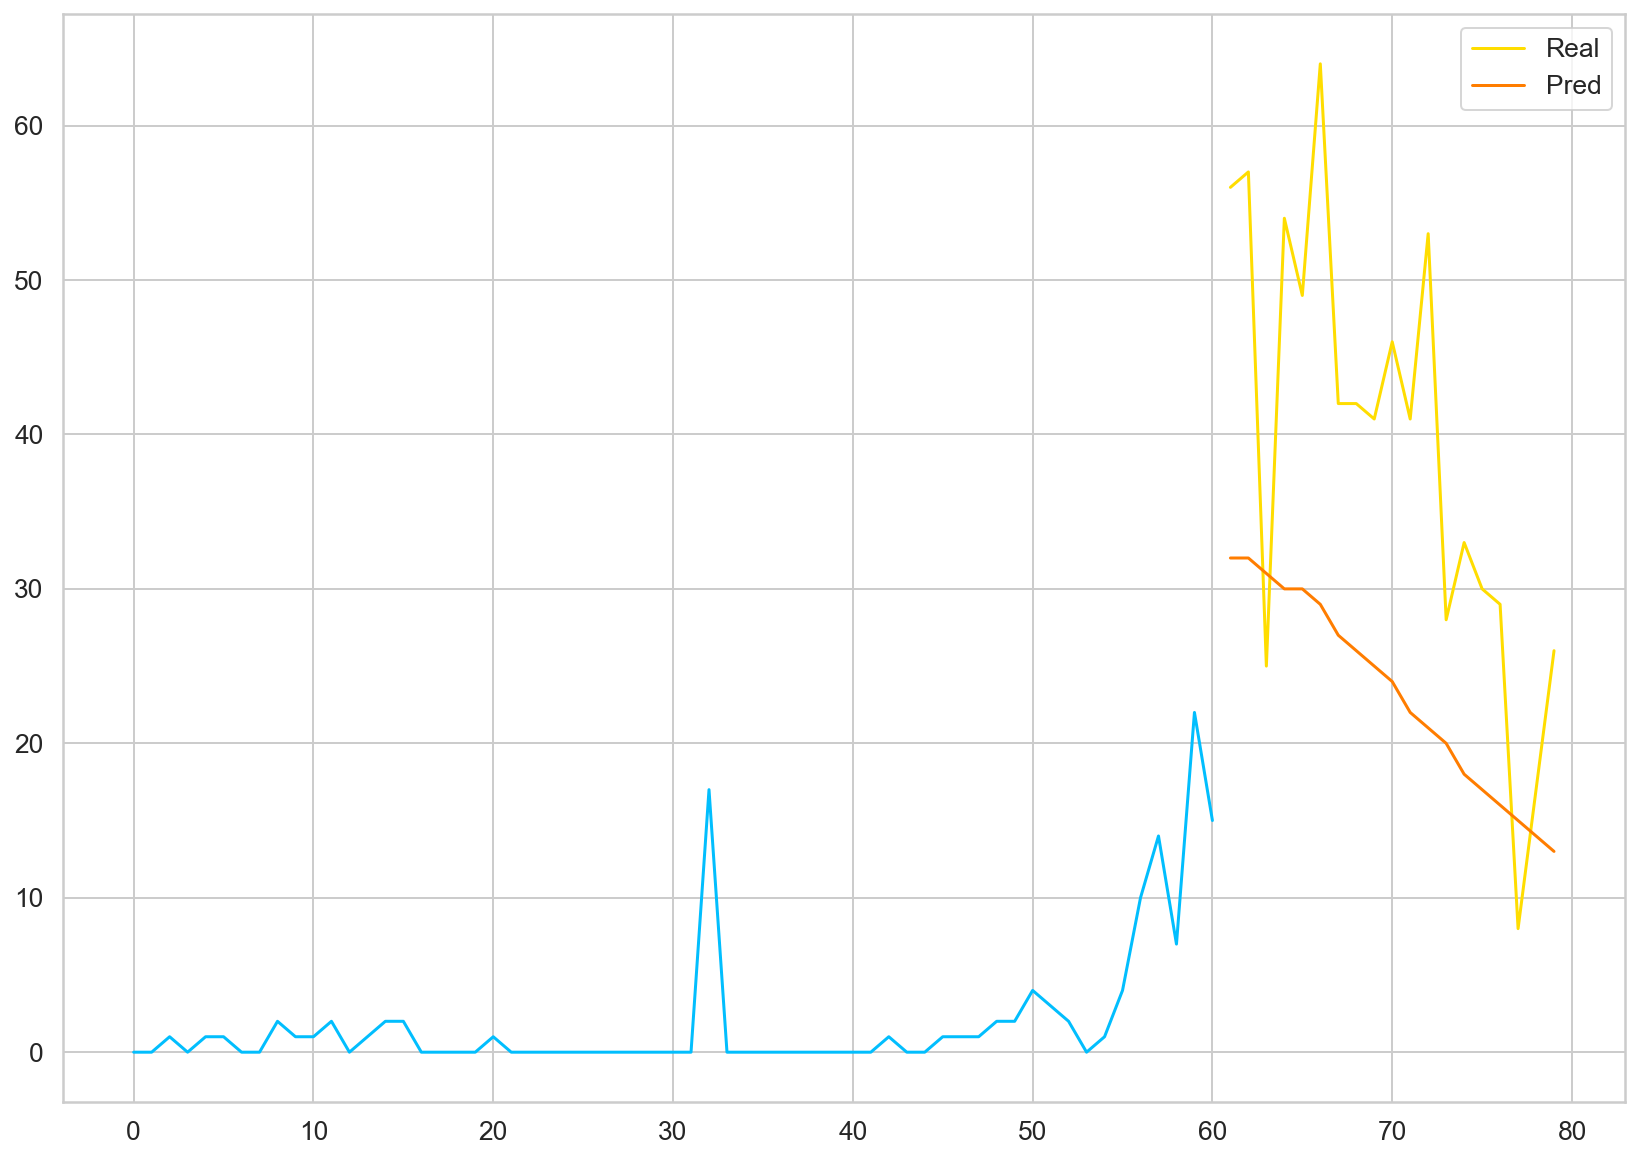

In [134]:
plt.plot(range(y_train.__len__()),yscaler.inverse_transform(y_train)[:, [-1]])
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),true_values, label='Real')
plt.plot(range(y_train.__len__(), y_train.__len__()+y_test.__len__()),pred_values_ceiled, label='Pred')
plt.legend()

# Use all data for training

In [135]:
# X변수들과 y변수 구분
X_all = df.iloc[:,:-1]
y_all = df.iloc[:,-1]

In [136]:
# MinMaxScaler을 통한 스케일링
scaler = MinMaxScaler()
# X scaler 생성
Xscaler = scaler.fit(X_all)
# Y scaler 생성
yscaler = scaler.fit(y_all.values.reshape(-1,1))

# 스케일링 적용
X_all = Xscaler.transform(X_all)
y_all = yscaler.transform(y_all.values.reshape(-1,1))
y_all = y_all.flatten()

In [137]:
y_all

array([0.      , 0.      , 0.015625, 0.      , 0.015625, 0.015625,
       0.      , 0.      , 0.03125 , 0.015625, 0.015625, 0.03125 ,
       0.      , 0.015625, 0.03125 , 0.03125 , 0.      , 0.      ,
       0.      , 0.      , 0.015625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.265625, 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.015625, 0.      , 0.      , 0.015625, 0.015625, 0.015625,
       0.03125 , 0.03125 , 0.0625  , 0.046875, 0.03125 , 0.      ,
       0.015625, 0.0625  , 0.15625 , 0.21875 , 0.109375, 0.34375 ,
       0.234375, 0.328125, 0.421875, 0.875   , 0.890625, 0.390625,
       0.84375 , 0.765625, 1.      , 0.65625 , 0.65625 , 0.640625,
       0.71875 , 0.640625, 0.828125, 0.4375  , 0.515625, 0.46875 ,
       0.453125, 0.125   , 0.265625, 0.40625 , 0.265625, 0.171875])

In [138]:
print("X_all : ", X_all.shape)
print("y_all : ", y_all.shape)

X_all :  (84, 23)
y_all :  (84,)


In [139]:
# LSTM 사용을 위한 시퀀스 데이터 형성 함수

def create_sequences1(array, seq_length):
    res = []
    
    for i in range(len(array)-seq_length-1):
        tmp = array[i:(i+seq_length)]
        res.append(tmp)
        
    return res

In [140]:
X_all = create_sequences1(X_all, seq_length)
y_all = create_sequences1(y_all, seq_length)
X_all = torch.from_numpy(np.array(X_all)).float()
y_all = torch.from_numpy(np.array(y_all)).float()

In [141]:
model = CoronaVirusPredictor(
  n_features=n_features,
  n_hidden=n_hidden,
  seq_len=seq_length,
  n_layers=n_layers
)
model, train_hist, _ = train_model(model, X_all, y_all, num_epochs=num_epochs, lr=lr)

Epoch 0 train loss: 0.025213617831468582
Epoch 10 train loss: 0.02101481892168522
Epoch 20 train loss: 0.01733359321951866
Epoch 30 train loss: 0.014154908247292042
Epoch 40 train loss: 0.011471007019281387
Epoch 50 train loss: 0.009285548701882362
Epoch 60 train loss: 0.007612151093780994
Epoch 70 train loss: 0.006462933495640755
Epoch 80 train loss: 0.0058169919066131115
Epoch 90 train loss: 0.005567802116274834
Epoch 100 train loss: 0.005505688954144716
Epoch 110 train loss: 0.005460008978843689
Epoch 120 train loss: 0.00540092121809721
Epoch 130 train loss: 0.0053308941423892975
Epoch 140 train loss: 0.005240905098617077
Epoch 150 train loss: 0.005129680503159761
Epoch 160 train loss: 0.005008467007428408
Epoch 170 train loss: 0.004888305906206369
Epoch 180 train loss: 0.004776411224156618
Epoch 190 train loss: 0.004673656541854143
Epoch 200 train loss: 0.004578225314617157
Epoch 210 train loss: 0.004487680271267891
Epoch 220 train loss: 0.004399299621582031
Epoch 230 train loss: 0

# Predicting future cases

In [142]:
DAYS_TO_PREDICT = 14
with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        #test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [143]:
# Prediction value 스케일링 역변환
pred_values = yscaler.inverse_transform(np.array(preds).reshape(-1,1))

In [144]:
# 예측값 반올림
import math

pred_values_ceiled = list(map(lambda x: math.ceil(x), pred_values))
predicted_cases=pred_values_ceiled
predicted_cases

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5]

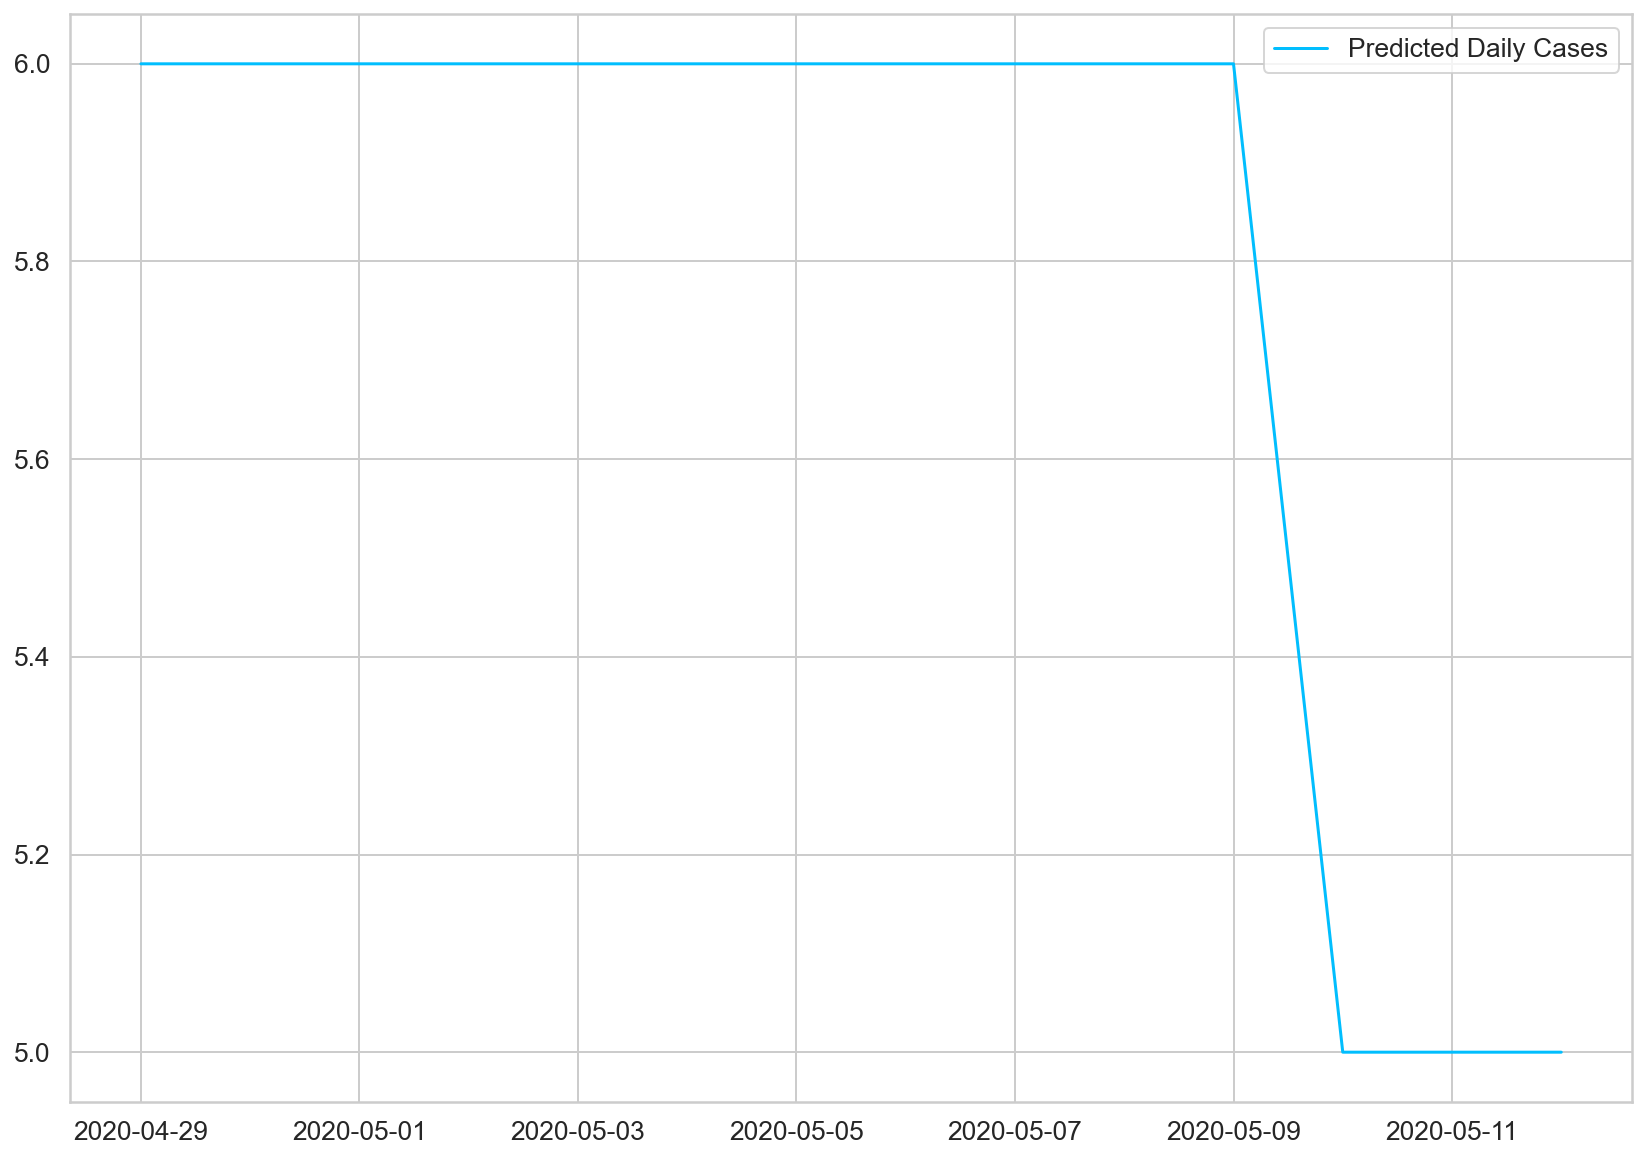

In [145]:
predicted_index = pd.date_range(
  start=df.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)
predicted_index = pd.to_datetime(predicted_index, format='%Y%m%d')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [146]:
preds_ = pd.DataFrame(predicted_cases)
df.index = pd.to_datetime(df.index)

In [148]:
df['target']

Date
2020-02-05     2.0
2020-02-06     2.0
2020-02-07     0.0
2020-02-08     0.0
2020-02-09     0.0
              ... 
2020-04-24     2.0
2020-04-25     4.0
2020-04-26    10.0
2020-04-27     7.0
2020-04-28    12.0
Name: target, Length: 84, dtype: float64

In [149]:
preds_

,0
2020-04-29,6
2020-04-30,6
2020-05-01,6
2020-05-02,6
2020-05-03,6
2020-05-04,6
2020-05-05,6
2020-05-06,6
2020-05-07,6
2020-05-08,6


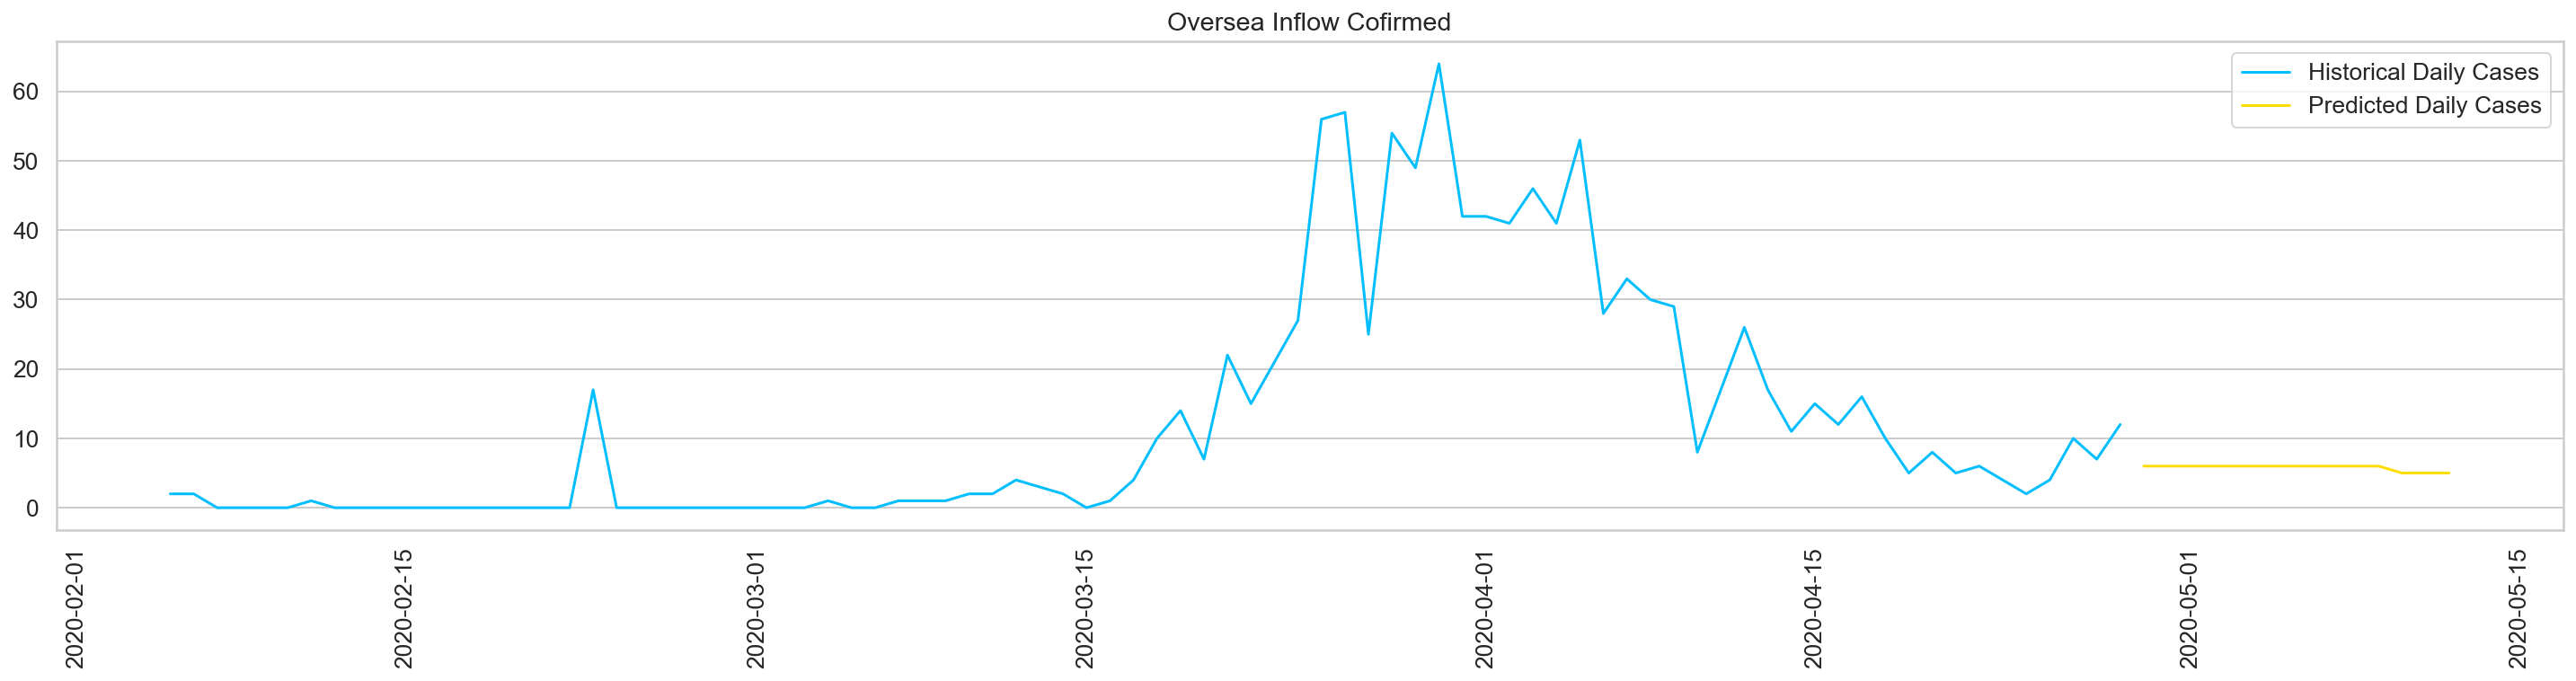

In [147]:
plt.figure(figsize=(25,5))
plt.plot(df['target'].astype(int), label='Historical Daily Cases')
plt.plot(preds_, label='Predicted Daily Cases')
plt.xticks(rotation=90)
plt.title("Oversea Inflow Cofirmed")
plt.grid(axis='x')
plt.legend();